In [26]:
import igraph as ig
import seaborn as sns
import math
import numpy as np
from tqdm import tqdm

In [3]:
# Initialize constants
N = 256 # Number of nodes, usually a square number
epsilon = 0.04 # Standard deviation of opinions required to terminate
trials = 1000 # Number of trials to calculate convergence time

In [4]:
# Library config
ig.config['plotting.backend'] = 'matplotlib'

## Line graph

This graph consists of $N$ nodes in a line, where each node is connected to its two neighbors.

<AxesSubplot: >

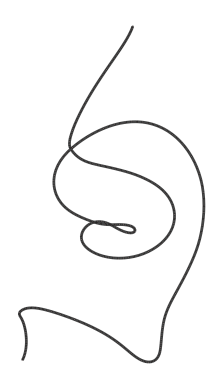

In [5]:
g_line = ig.Graph.Ring(n=N, circular=False)
ig.plot(g_line)

## Ring graph

This graph consists of $N$ nodes arranged in a ring, where each node is connected with its two neighbors.

<AxesSubplot: >

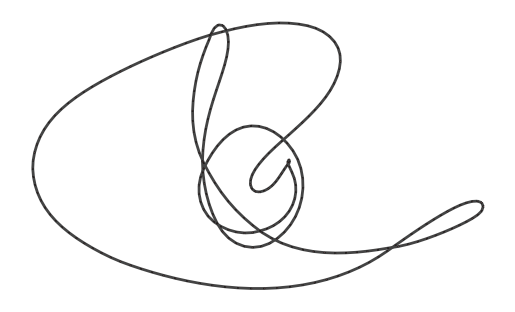

In [6]:
g_ring = ig.Graph.Ring(n=N, circular=True)
ig.plot(g_ring)

## Lattice graph

This consists of $N^2$ nodes arranged in a square lattice, where each node is connected to its four directly adjacent neighbors.

<AxesSubplot: >

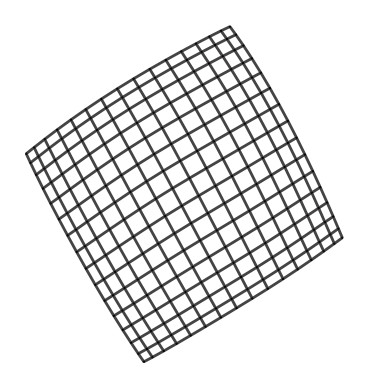

In [7]:
g_lattice = ig.Graph.Lattice(dim=[int(math.sqrt(N)), int(math.sqrt(N))], circular=False)
ig.plot(g_lattice)

## Star graph

The star graph consists of $N$ nodes, $N-1$ of which are connected to a single central node.

<AxesSubplot: >

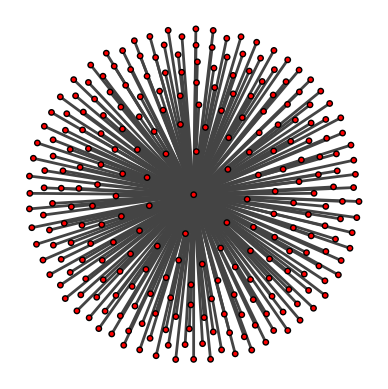

In [8]:
g_star = ig.Graph.Star(N)
ig.plot(g_star)

## Complete graph

The complete graph consists of $N$ nodes, all of which are connected to each other by $O(N^2)$ links. *[The graph is not plotted due to time constraints.]*

In [9]:
g_complete = ig.Graph.Full(N)

## Tree graph
The tree graph consists of a root node, with each node having a set number of "children" to which it is connected.

<AxesSubplot: >

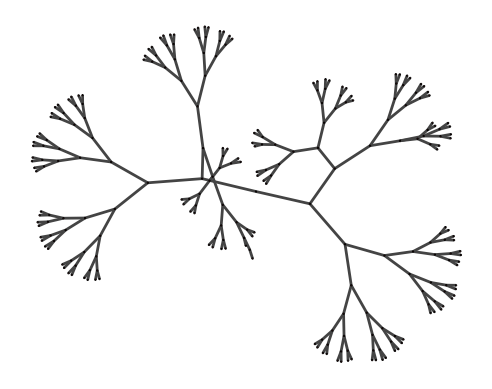

In [61]:
g_tree = ig.Graph.Tree(n=N, children=2)
ig.plot(g_tree)

## Barabási-Albert (BA) model

The Barabási-Albert model is a method for generating scale-free and connected graphs, adding new nodes and linking them to nodes with a probability proportional to their degree.

<AxesSubplot: >

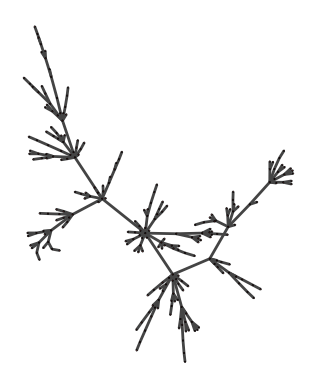

In [10]:
g_ba = ig.Graph.Barabasi(n=N, m=1)
ig.plot(g_ba)

## Watts-Strogatz (WS) model

<AxesSubplot: >

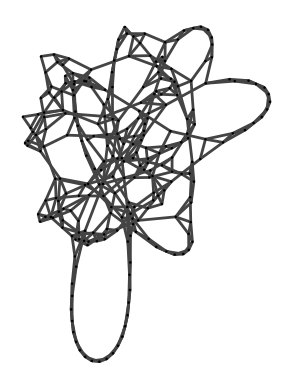

In [11]:
g_ws = ig.Graph.Watts_Strogatz(dim=1, size=N, nei=2, p=0.05)
ig.plot(g_ws)

# Developing the consensus algorithm

In [12]:
def time_to_convergence_unweighted(g_, epsilon=epsilon):
    adj = np.array(g_.get_adjacency().data)
    np.fill_diagonal(adj, 1)
    adj = adj / np.linalg.norm(adj, axis=1, ord=1).reshape((N,1))
    
    # assign uniformly random initial preferences on [0,1)
    opinions = np.random.rand(N)

    t = 0
    while(np.std(opinions) > epsilon):
        opinions = np.dot(adj, opinions) # matrix multiplication of modified normalized adjacency matrix with opinion vector
        t += 1
    
    return t

In [13]:
def time_to_convergence_weighted(g_, epsilon=epsilon):
    adj = np.array(g_.get_adjacency().data)
    degree = np.array(g_.degree())
    np.fill_diagonal(adj, 1)
    adj = adj * degree # weight by degree
    adj = adj / np.linalg.norm(adj, axis=1, ord=1).reshape((N,1))
    
    # assign uniformly random initial preferences on [0,1)
    opinions = np.random.rand(N)

    t = 0
    while(np.std(opinions) > epsilon):
        opinions = np.dot(adj, opinions) # matrix multiplication of modified normalized adjacency matrix with opinion vector
        t += 1
    
    return t

In [54]:
def time_to_convergence_weighted_discrete(g_, epsilon=epsilon):
    adj = np.array(g_.get_adjacency().data)
    degree = np.array(g_.degree())
    np.fill_diagonal(adj, 1)
    adj = adj * degree # weight by degree
    adj = adj / np.linalg.norm(adj, axis=1, ord=1).reshape((N,1))
    
    # assign uniformly random initial preferences on [0,1)
    opinions = np.round(np.random.rand(N))

    t = 0
    while(np.abs(0.5 - np.average(opinions)) < 0.4): # (average opinion) is in (0.1, 0.9)
        opinions = np.round(np.dot(adj, opinions)) # matrix multiplication of modified normalized adjacency matrix with opinion vector
        t += 1
        if(t > 1000): # convergence might not be achieved at all due to oscillations
            break
    
    return t

### Calculating time-to-consensus (TTC) values

In [14]:
t_line_uw = [time_to_convergence_unweighted(g_line) for _ in tqdm(range(trials))]
t_ring_uw = [time_to_convergence_unweighted(g_ring) for _ in tqdm(range(trials))]
t_lattice_uw = [time_to_convergence_unweighted(g_lattice) for _ in tqdm(range(trials))]
t_star_uw = [time_to_convergence_unweighted(g_star) for _ in tqdm(range(trials))]
t_complete_uw = [time_to_convergence_unweighted(g_complete) for _ in tqdm(range(trials))]
t_ba_uw = [time_to_convergence_unweighted(g_ba) for _ in tqdm(range(trials))]
t_ws_uw = [time_to_convergence_unweighted(g_ws) for _ in tqdm(range(trials))]
t_tree_uw = [time_to_convergence_unweighted(g_tree) for _ in tqdm(range(trials))]


100%|██████████| 1000/1000 [00:06<00:00, 163.24it/s]


In [15]:
t_line_w = [time_to_convergence_weighted(g_line) for _ in tqdm(range(trials))]
t_ring_w = [time_to_convergence_weighted(g_ring) for _ in tqdm(range(trials))]
t_lattice_w = [time_to_convergence_weighted(g_lattice) for _ in tqdm(range(trials))]
t_star_w = [time_to_convergence_weighted(g_star) for _ in tqdm(range(trials))]
t_complete_w = [time_to_convergence_weighted(g_complete) for _ in tqdm(range(trials))]
t_ba_w = [time_to_convergence_weighted(g_ba) for _ in tqdm(range(trials))]
t_ws_w = [time_to_convergence_weighted(g_ws) for _ in tqdm(range(trials))]
t_tree_w = [time_to_convergence_weighted(g_tree) for _ in tqdm(range(trials))]


100%|██████████| 1000/1000 [00:07<00:00, 138.11it/s]


In [57]:
t_line_wd = [time_to_convergence_weighted_discrete(g_line) for _ in tqdm(range(trials))]
t_ring_wd = [time_to_convergence_weighted_discrete(g_ring) for _ in tqdm(range(trials))]
t_lattice_wd = [time_to_convergence_weighted_discrete(g_lattice) for _ in tqdm(range(trials))]
t_star_wd = [time_to_convergence_weighted_discrete(g_star) for _ in tqdm(range(trials))]
t_complete_wd = [time_to_convergence_weighted_discrete(g_complete) for _ in tqdm(range(trials))]
t_ba_wd = [time_to_convergence_weighted_discrete(g_ba) for _ in tqdm(range(trials))]
t_ws_wd = [time_to_convergence_weighted_discrete(g_ws) for _ in tqdm(range(trials))]
t_tree_wd = [time_to_convergence_weighted_discrete(g_ws) for _ in tqdm(range(trials))]





















































































































































































































































































































































































































































































100%|██████████| 1000/1000 [00:29<00:00, 33.55it/s]






































































































































































































































































































































































































































































100%|██████████| 1000/1000 

### Histograms of TTC

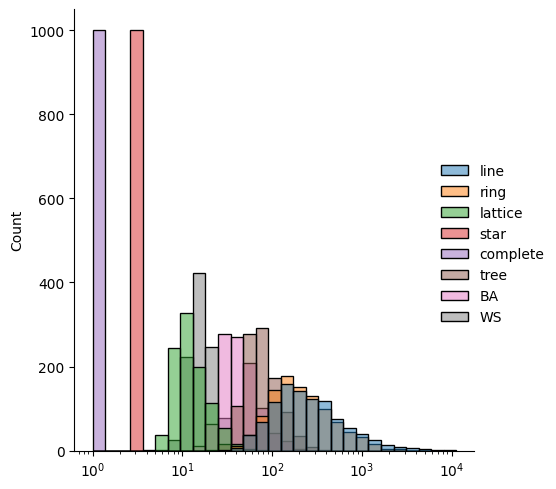

In [66]:
# https://stackoverflow.com/questions/36362624/how-to-plot-multiple-histograms-on-same-plot-with-seaborn
# https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions

hist_uw = sns.displot([t_line_uw, t_ring_uw, t_lattice_uw, t_star_uw, t_complete_uw, t_tree_uw, t_ba_uw, t_ws_uw], log_scale=True)

labels = ['line', 'ring', 'lattice', 'star', 'complete', 'tree', 'BA', 'WS']
for t, l in zip(hist_uw._legend.texts, labels):
    t.set_text(l)

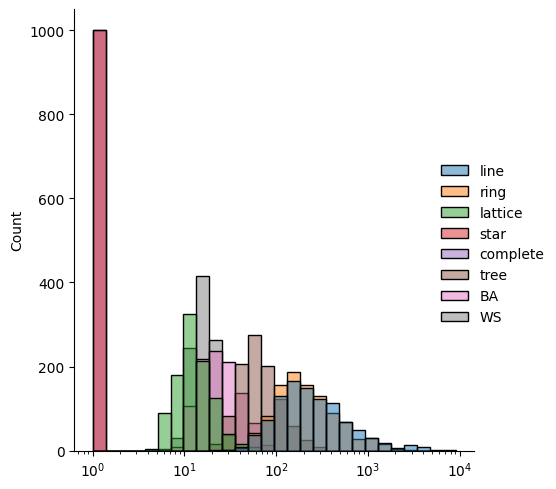

In [67]:
hist_w = sns.displot([t_line_w, t_ring_w, t_lattice_w, t_star_w, t_complete_w, t_tree_w, t_ba_w, t_ws_w], log_scale=True)

labels = ['line', 'ring', 'lattice', 'star', 'complete', 'tree', 'BA', 'WS']
for t, l in zip(hist_w._legend.texts, labels):
    t.set_text(l)

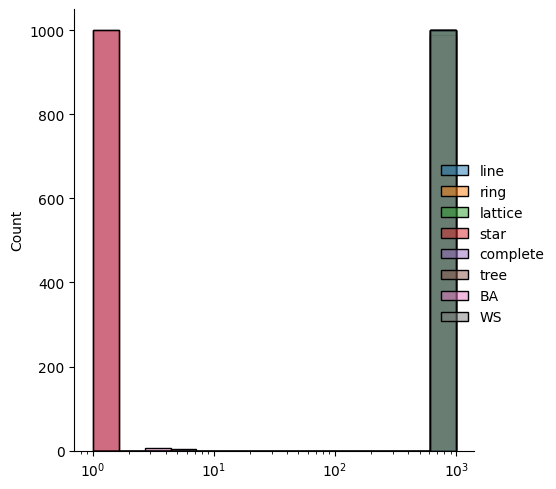

In [68]:
hist_wd = sns.displot([t_line_wd, t_ring_wd, t_lattice_wd, t_star_wd, t_complete_wd, t_tree_wd, t_ba_wd, t_ws_wd], log_scale=True)

labels = ['line', 'ring', 'lattice', 'star', 'complete', 'tree', 'BA', 'WS']
for t, l in zip(hist_wd._legend.texts, labels):
    t.set_text(l)

## Statistical analysis

### Average time to sufficient convergence

In [70]:
print("line average:", np.average(t_line_uw)) # information is bad
print("ring average:", np.average(t_ring_uw)) # line of half the length, but you add only one edge
print("lattice average:", np.average(t_lattice_uw)) # reduced to maximum distance as L1-norm from (0,0) to (N,N) = 2N
print("star average:", np.average(t_star_uw)) # mathematically provable
print("complete average:", np.average(t_complete_uw)) # mathematically provable
print("tree average:", np.average(t_tree_uw)) # mathematically provable
print("BA average:", np.average(t_ba_uw))
print("WS average:", np.average(t_ws_uw))

line average: 419.356
ring average: 290.858
lattice average: 14.095
star average: 3.0
complete average: 1.0
tree average: 83.931
BA average: 48.128
WS average: 17.016


In [71]:
print("line average (weighted):", np.average(t_line_w)) # information is bad
print("ring average (weighted):", np.average(t_ring_w)) # line of half the length, but you add only one edge
print("lattice average (weighted):", np.average(t_lattice_w)) # reduced to maximum distance as L1-norm from (0,0) to (N,N) = 2N
print("star average (weighted):", np.average(t_star_w)) # mathematically provable
print("complete average (weighted):", np.average(t_complete_w)) # mathematically provable
print("tree average (weighted):", np.average(t_tree_w)) # mathematically provable
print("BA average (weighted):", np.average(t_ba_w))
print("WS average (weighted):", np.average(t_ws_w))

line average (weighted): 408.957
ring average (weighted): 292.67
lattice average (weighted): 14.171
star average (weighted): 1.0
complete average (weighted): 1.0
tree average (weighted): 75.551
BA average (weighted): 27.167
WS average (weighted): 16.746


## Eigenvalue calculations

In [89]:
adj = np.array(g_ws.get_adjacency().data)
np.fill_diagonal(adj, 1)
adj = adj / np.linalg.norm(adj, axis=1, ord=1).reshape((N,1))
eig = np.linalg.eigvals(adj)
(eig >= 0.99).sum()

1

In [83]:
adj = np.array(g_line.get_adjacency().data)
degree = np.array(g_line.degree())
np.fill_diagonal(adj, 1)
adj = adj * degree # weight by degree
adj = adj / np.linalg.norm(adj, axis=1, ord=1).reshape((N,1))
eig = np.linalg.eigvals(adj)
(eig >= 0.99999).sum()

1